In [ ]:
from abc import abstractmethod
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

__The Task of RiverSwim__

![](https://github.com/alexunderch/Bachelor_materials/raw/main/ml-mipt_advanced/lab1_DL/extra_imgs/riverswim.png)


In [ ]:
%%writefile riversvim.py
import numpy as np

class RiverSwim:
    def __init__(self, 
                 n_interm_states  = 4, # число состояний (без учета крайних)
                 max_steps   = 16, # максимальное число шагов
                 left_side_reward   = 5. / 1000, 
                 right_side_reward   = 1.0, 
                 seed = 42):
        self.rs = np.random.RandomState(seed)
        self._max_steps = max_steps
        self._interm_states = n_interm_states

        self._steps = 0
        self._current_state = 1 #we always start in s1 at the very beginning

        self.left_side_reward = left_side_reward
        self.right_side_reward = right_side_reward
        
    @property
    def action_count(self) -> int:
        """
        actually we have 2 actions here:
        0: stay where we are
        1: make an effort to move further
        """ 
        return 2
    
    @property
    def states_count(self) -> int:
        """
        initial state + terminal state + numerous of intermediate states
        """
        return 2 + self._interm_states
    
    def _get_probs(self, action: int):
        """
        args:
        -- action: int ==> stay(0) or go(1)
        returns:
        -- probalities: list ==> stacked as follows: [drift backwards,
                                                      stay here
                                                      move further]
        sum of probabilies along axis 0 is 1.
        """
        #stay where we are:
        if action == 0: 
            if self._current_state == 0: #initial state
                return [0.00, 1.00, 0.00]
            else: #we do not have choice
                return [1.00, 0.00, 0.00]
        #try to move:    
        elif action == 1:
            if self._current_state == 0: #initial state
                return [0.00, 0.40, 0.60]
            if self._current_state == self.states_count - 1: #terminal state
                return [0.40, 0.60, 0.00]
            else: #intermediate states
                return [0.05, 0.60, 0.35]

    def step(self, action: int) -> tuple:
        reward = 0.0
        """
        args:
        -- action: int ==> stay(0) or go(1)
        returns: 
        -- (state: int, reward: float, is_done: bool): tuple, game info during the game
        """
        if self._steps >= self._max_steps: return (self._current_state, reward, True)
        
        transition = self.rs.choice(range(3), p = self._get_probs(action))
        if transition == 0: self._current_state -= 1 #move backwards
        elif transition == 1: pass #stay
        else: self._current_state += 1 #move forward

        if self._current_state == 0: reward = self.left_side_reward
        elif self._current_state == self.states_count - 1: reward = self.right_side_reward
        
        self._steps += 1
        return (self._current_state, reward, False)



Writing riversvim.py


In [ ]:
%%writefile qlearning.py
from collections import defaultdict
import random
import math
import numpy as np


class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions, seed = 42):
        """
        Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value
        !!!Important!!!
        Note: please avoid using self._qValues directly. 
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount
        self.rs = np.random.RandomState(seed)

    def get_q_matrix(self):
        """Returns Q (n_states x n_actions)"""
        matrix = np.zeros((len(self._qvalues), 2))
        for state in range(matrix.shape[0]):
            for action in range(matrix.shape[1]):
                matrix[state][action] = self.get_qvalue(state, action)
        return matrix
        
    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0: return 0.0

        value = max([self.get_qvalue(state, action) for action in possible_actions])

        return value

    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        qvalue = (1 - learning_rate) * self.get_qvalue(state, action) + \
                 learning_rate * (reward +  gamma * self.get_value(next_state))

        self.set_qvalue(state, action, qvalue)

    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values). 
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0: return None

        action_value_dict = {action: self.get_qvalue(state, action) for action in possible_actions}
        best_action = sorted(action_value_dict, key = action_value_dict.get, reverse = True)[0]
        return best_action

    def get_action(self, state):
        # Pick Action
        possible_actions = self.get_legal_actions(state)
        action = None

        # If there are no legal actions, return None
        if len(possible_actions) == 0: return None
        # agent parameters:
        epsilon = self.epsilon
        exploration_thr = self.rs.random()

        if  exploration_thr < epsilon: 
            chosen_action = self.rs.choice(possible_actions)
        else: chosen_action = self.get_best_action(state)

        return chosen_action
    def start_episode(self, config = None):
        """if any episode should be started in special way"""
        pass



Overwriting qlearning.py


In [ ]:
%%writefile psrl.py
import numpy as np
class PSRLAgent:
    def __init__(self, n_states, n_actions):
        self.n_states = n_states
        self.n_actions = n_actions
        self.gamma = 0.99   #discount     
        #1)transilition sampling -- Diriclet distribution
        self._transition_counter = 1. / self.n_states * np.ones((n_states, n_states, n_actions))
        #2)reward sampling -- Normal distribution
        self._mu = np.ones((n_states, n_actions), dtype = np.float32) 
        self._state_action_counter = np.ones((n_states, n_actions), dtype = np.float32)

        self._alpha = np.ones((n_states, n_actions), dtype = np.float32)
        self._beta = np.ones((n_states, n_actions), dtype = np.float32)
        #3) learning observations from reward
        self._reward_mu_obs = np.ones((n_states, n_actions), dtype = np.float32)
        self._reward_var_obs = np.ones((n_states, n_actions), dtype = np.float32)
        self._Tau0 = np.ones((n_states, n_actions), dtype = np.float32)

    def _value_iteration(self, transitions, rewards):
        #hyperparameters        
        num_iter = 1e3  #num steps to iterate     
        delta = 1e-3  # early convergence     

        # initialize V(s)
        all_states = list(range(self.n_states))
        all_actions = list(range(self.n_actions))
        V = np.zeros((self.n_states, 1)) 
        #just filling the gaps
        for i in range(num_iter):
            V_next = np.zeros((self.n_states, 1))
            for s in all_states:
                list_Q = []
                #r + gamma * <T(s, a)V(s)> like in paper
                for a in all_actions: list_Q.append(rewards[s, a] + self.gamma * np.dot(transitions[s, : ,a], V))
                V_next[s] = np.max(list_Q)
                
            # compute difference
            diff = np.max(np.abs(V_next - V))
            V = V_next
            # criteria of early stopage
            if diff < delta: break
        return V

    def sample_normal_gamma(self, mu, sigma, alpha, beta):
        """Sample from normal gamma distribution"""
        _tau = np.random.gamma(alpha, beta)
        n = np.random.normal(mu, 1.0 / np.sqrt(sigma * _tau))
        return n, _tau

    def start_episode(self):
        mu_0 = self._mu
        tau_0 = self._Tau0
        alpha_0 = self._alpha
        beta_0 = self._beta
        sa_counts = self._state_action_counter
        mean_r = self._reward_mu_obs
        var_r = self._reward_var_obs
        #using conjugate distribution to sample
        mu_p = (tau_0 * mu_0 + sa_counts * mean_r ) / (tau_0 + sa_counts)
        tau_p = tau_0 +  sa_counts
        alpha_p = alpha_0 + sa_counts / 2
        beta_p = beta_0 + 0.5 * sa_counts * var_r + 0.5 * np.square(mean_r - mu_0) * (sa_counts * tau_0) / (tau_0 + sa_counts)
        #sampling
        self._sampled_transitions = np.apply_along_axis(np.random.dirichlet, 1, self._transition_counter)
        sampled_reward_Mus, sampled_reward_stds = self.sample_normal_gamma(mu_p, tau_p, alpha_p, beta_p)
        self._sampled_rewards = sampled_reward_Mus
        #counting V(s)
        self._current_value_function = self._value_iteration(
            self._sampled_transitions,
            self._sampled_rewards)
        
    def get_action(self, state):
        #just using greedy strategy
        return np.argmax(self._sampled_rewards[state] + np.dot(np.transpose(self._current_value_function), self._sampled_transitions[state]))

    def update(self, state, action, reward, next_state):
        self._transition_counter[state, next_state, action] += 1
        self._state_action_counter[state, action] += 1

        sa_counter = self._state_action_counter[state, action]
        prev_mean_reward = self._reward_mu_obs[state, action]
        prev_var_reward = self._reward_var_obs[state, action]
        #normalized mean approx
        self._reward_mu_obs[state, action] = ((sa_counter - 1) * prev_mean_reward + 1 * reward ) / sa_counter
        self._reward_var_obs[state, action] = ((sa_counter - 1) * prev_var_reward + 1 * np.square(reward - prev_mean_reward)) / sa_counter

    def get_q_matrix(self):
        Q = np.zeros((self.n_states, self.n_actions))       
        for state in range(self.n_states):
            for action in range(self.n_actions):
                Q[state][action] = self._sampled_rewards[state][action] +  \
                (np.transpose(self._current_value_function).dot(self._sampled_transitions[:, state, action][:, None]))[0]
        return Q


Overwriting psrl.py


![](https://github.com/alexunderch/Bachelor_materials/raw/main/ml-mipt_advanced/lab1_DL/extra_imgs/psrl.png)

Now we will implement Thompson Sampling for MDP!

General algorithm:

>**for** episode $k = 1,2,...$ **do**
>> sample $M_k \sim f(\bullet\ |\ H_k)$

>> compute policy $\mu_k$ for $M_k$

>> **for** time $t = 1, 2,...$ **do**

>>> take action  $a_t$ from $\mu_k$ 

>>> observe $r_t$ and $s_{t+1}$
>>> update $H_k$

>> **end for**

>**end for**

In our case we will model $M_k$ with two matrices: transition and reward. Transition matrix is sampled from dirichlet distribution. Reward matrix is sampled from normal-gamma distribution.

Distributions are updated with bayes rule - see continuous distribution section at https://en.wikipedia.org/wiki/Conjugate_prior

Article on PSRL - https://arxiv.org/abs/1306.0940

In [ ]:
n_interm_states = 10
max_steps = 128
n_episodes = 501
n_actions = 2

In [ ]:
import imp
import qlearning
import psrl
imp.reload(psrl)
imp.reload(qlearning)

from qlearning import QLearningAgent
from psrl import PSRLAgent
from riversvim import RiverSwim


def moving_average(x, span = 100): return pd.DataFrame(
    {'x': np.asarray(x)}).x.ewm(span = span).mean().values


agent_ql = QLearningAgent(alpha = 0.25, epsilon = 0.33, discount = 0.99,
                          get_legal_actions = lambda s: range(n_actions))

agent_psrl = PSRLAgent(n_interm_states + 2, n_actions)

def play_game(agent = agent_ql):
    def get_actions(agent):    
        fig = plt.figure(figsize = (16, 8))
        ax = fig.add_subplot(111)
        matrix = agent.get_q_matrix()
        ax.matshow(matrix.T)
        ax.set_yticklabels(['', 'no act', 'swim'])
        plt.xlabel("State")
        plt.ylabel("Action")
        plt.title("Values of state-action pairs")
        plt.show()

    episode_rewards = []

    for ep in range(n_episodes):
        river_swim = RiverSwim(n_interm_states, max_steps)

        state, ep_reward, is_done = river_swim._current_state, 0.0, False
        agent.start_episode()

        while not is_done:
            action = agent.get_action(state)
            next_state, reward, is_done = river_swim.step(action)
            agent.update(state, action, reward, next_state)
            
            state = next_state
            ep_reward += reward
            
        episode_rewards.append(ep_reward)
        if ep % 100 == 0:
            clear_output(True)
            
            print("checkpoint^ ep # {}".format(ep))
            print('mean reward =', np.mean(episode_rewards[-100:]))
            plt.figure(figsize = (16, 8))

            plt.xlabel("Episode count")
            plt.ylabel("Reward")

            plt.plot(moving_average(episode_rewards), label = 'greedy')
            plt.grid()
            plt.legend()
            plt.show()
    #####ligther is better
    _ = get_actions(agent)

checkpoint^ ep # 500
mean reward = 0.5756000000000003


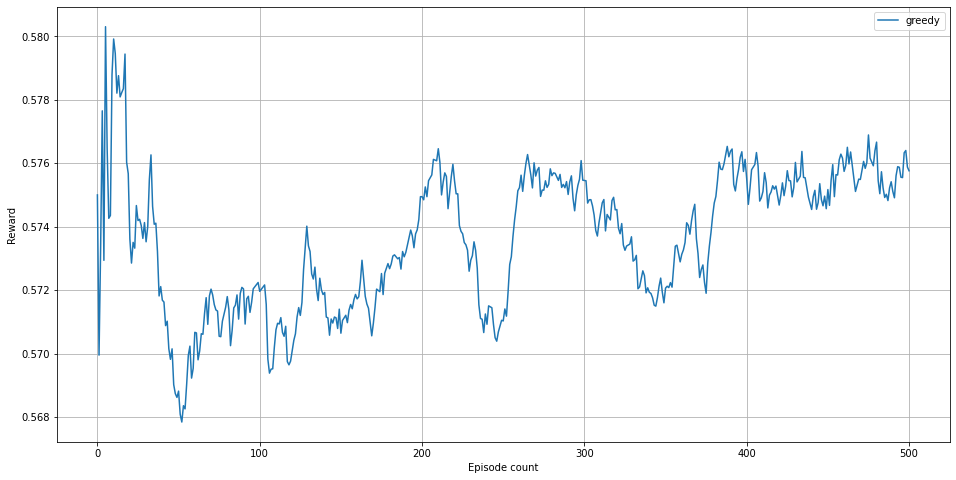

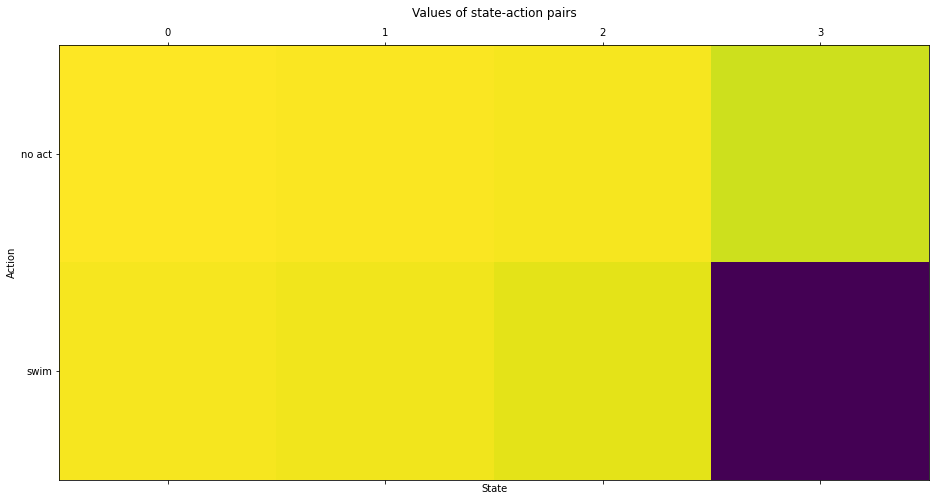

In [ ]:
_ = play_game(agent = agent_ql)

checkpoint^ ep # 500
mean reward = 38.0


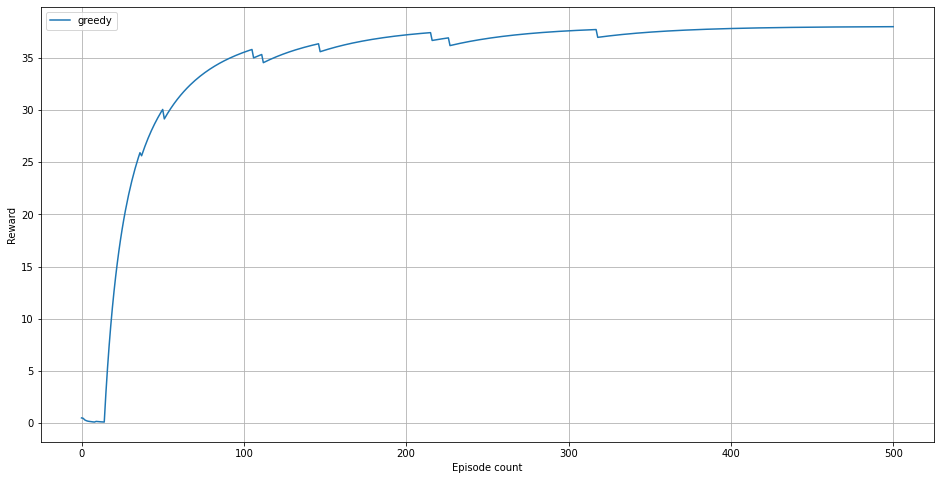

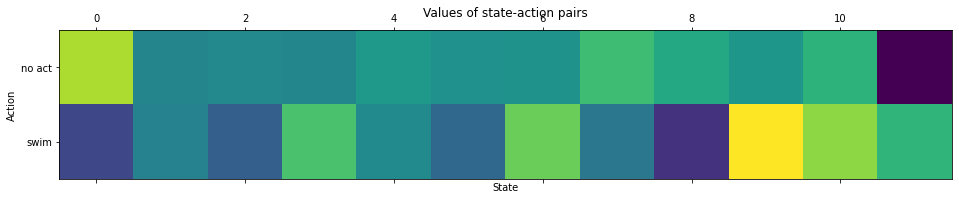

In [ ]:
_ = play_game(agent = agent_psrl)